In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import random
import importlib

In [2]:
# set device
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [3]:
#Architecture parameters and distributions of stimuli
N = 20

#p_x = torch.distributions.uniform.Uniform(0,10)
p_x = torch.distributions.exponential.Exponential(0.5)

#Training parameters
N_EPOCHS = 4000
N_SAMPLES = 30000
#lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE, shuffle = True)


decoder = MoGDecoder(N,x_min,x_max,x_sorted)
encoder = CategoricalEncoder(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))



#Define optimizer and parameters to iterate on
params = list(decoder.parameters()) + list(encoder.parameters())
#optimizer = torch.optim.SGD([
#                {'params': params[0:2]},
#                {'params': params[2],'lr':1e-2}
#                ],0.01)
optimizer=torch.optim.Adam(params, lr=1e-2)


#The mus are now initialized using a KMEANS algorithm 

In [13]:
torch.sort(decoder.mus, dim = 0)

torch.return_types.sort(
values=tensor([[ 0.0281],
        [ 0.0834],
        [ 0.1844],
        [ 0.3642],
        [ 0.6441],
        [ 1.0654],
        [ 1.7074],
        [ 2.4885],
        [ 2.5686],
        [ 2.5698],
        [ 2.5720],
        [ 2.5884],
        [ 2.5930],
        [ 2.6127],
        [ 3.6238],
        [ 4.9326],
        [ 6.5937],
        [ 8.5718],
        [10.6751],
        [14.4378]], grad_fn=<SortBackward>),
indices=tensor([[18],
        [ 6],
        [ 7],
        [ 0],
        [ 8],
        [12],
        [ 4],
        [11],
        [ 9],
        [ 1],
        [13],
        [ 2],
        [14],
        [17],
        [19],
        [ 3],
        [16],
        [ 5],
        [15],
        [10]]))

In [5]:
#training 
total_batch = int(N_SAMPLES/BATCH_SIZE)
print(total_batch)



60


In [6]:
#Loss computed as the average over the mini batches for each epoch
avg_loss = []
avg_mse = []
for epoch in range(N_EPOCHS):
    avg_loss_item=0
    avg_mse_item=0
    for i in range(total_batch):
        batch_start, batch_end = i*BATCH_SIZE, i*BATCH_SIZE + BATCH_SIZE
        x_batch= x_samples[batch_start:batch_end]
        loss = distortion_cat(x_batch, encoder, decoder) + rate_cat(x_batch, encoder, decoder)
        mse = MSE_cat(x_batch, decoder, encoder)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss_item += loss.item()/total_batch
        avg_mse_item += mse.item()/total_batch
    avg_loss.append(avg_loss_item)
    avg_mse.append(avg_mse_item)


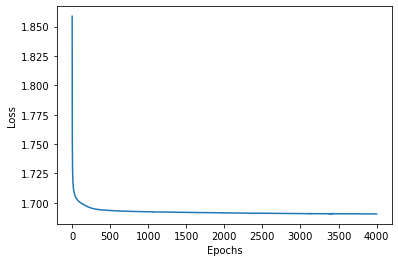

In [8]:
# LOSS
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(avg_loss)

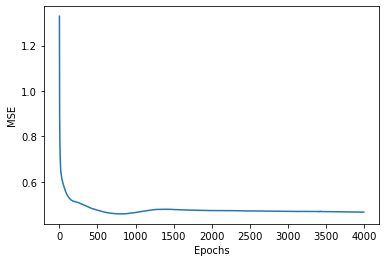

In [9]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.plot(avg_mse)

<ipython-input-10-fe7deec8310e>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(x_fine,F.softmax(encoder(x_fine)[:,:]))


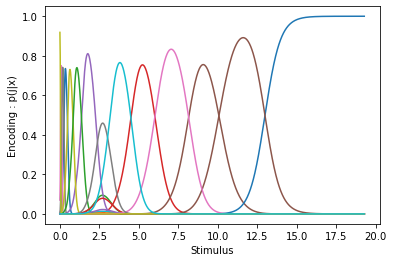

In [10]:
#Reproducing Woodford's plots: ENCODING
x_fine = torch.linspace(x_min,x_max,1000)[:,None]
with torch.no_grad():
    plt.xlabel("Stimulus")
    plt.ylabel("Encoding : p(j|x)")
    plt.plot(x_fine,F.softmax(encoder(x_fine)[:,:])) 

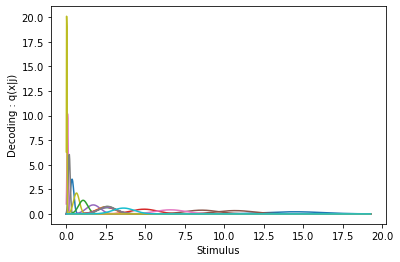

In [14]:
#DECODING

gaussian = torch.distributions.normal.Normal(decoder.mus, torch.exp(decoder.log_sigmas))
gauss_logprob = (gaussian.log_prob(x_fine.transpose(0,1))).transpose(0,1)

with torch.no_grad():
    plt.plot(x_fine, torch.exp(gauss_logprob[:,:]))
    plt.xlabel("Stimulus")
    plt.ylabel("Decoding : q(x|j)")